<a href="https://colab.research.google.com/github/getreadytoUG/KDT_WORK/blob/main/%ED%99%8D%EC%A4%80%ED%91%9C_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 팀과제.
* 케글에서 이미지 데이터를 선택하여 해당 이미지를 분류하는 문제를 푸는 프로젝트를 작성
* 깃허브에 예쁘게 올리기
* 월요일까지
* https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

# 1-0. 기본 세팅

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import random
import shutil
import torchvision.models as models

In [ ]:
os.environ["KAGGLE_USERNAME"] = "honghongjp"
os.environ["KAGGLE_KEY"] = "4b2184a2c233a46951a6216fd5f58982"

In [ ]:
!kaggle datasets download -d jehanbhathena/weather-dataset

100% 587M/587M [00:20<00:00, 38.3MB/s]
100% 587M/587M [00:20<00:00, 29.7MB/s]


In [ ]:
!unzip -q weather-dataset.zip

In [ ]:
# GPU 사용 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
data = os.listdir("dataset")
print(data)
print(len(data))

['snow', 'dew', 'hail', 'rain', 'glaze', 'rime', 'frost', 'sandstorm', 'fogsmog', 'lightning', 'rainbow']
11


# 1-1. 연습

In [ ]:
# 이미지 증강
# data_transforms
# train / validation

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
datasets = datasets.ImageFolder("./dataset", data_transform)
datasets

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: ./dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
train_size = int( 0.8 * len(datasets))
val_size = len(datasets) - train_size

random_seed = 1027

torch.manual_seed(random_seed)
dataset_train, dataset_val = random_split(datasets, [train_size, val_size])

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=32, shuffle=True)

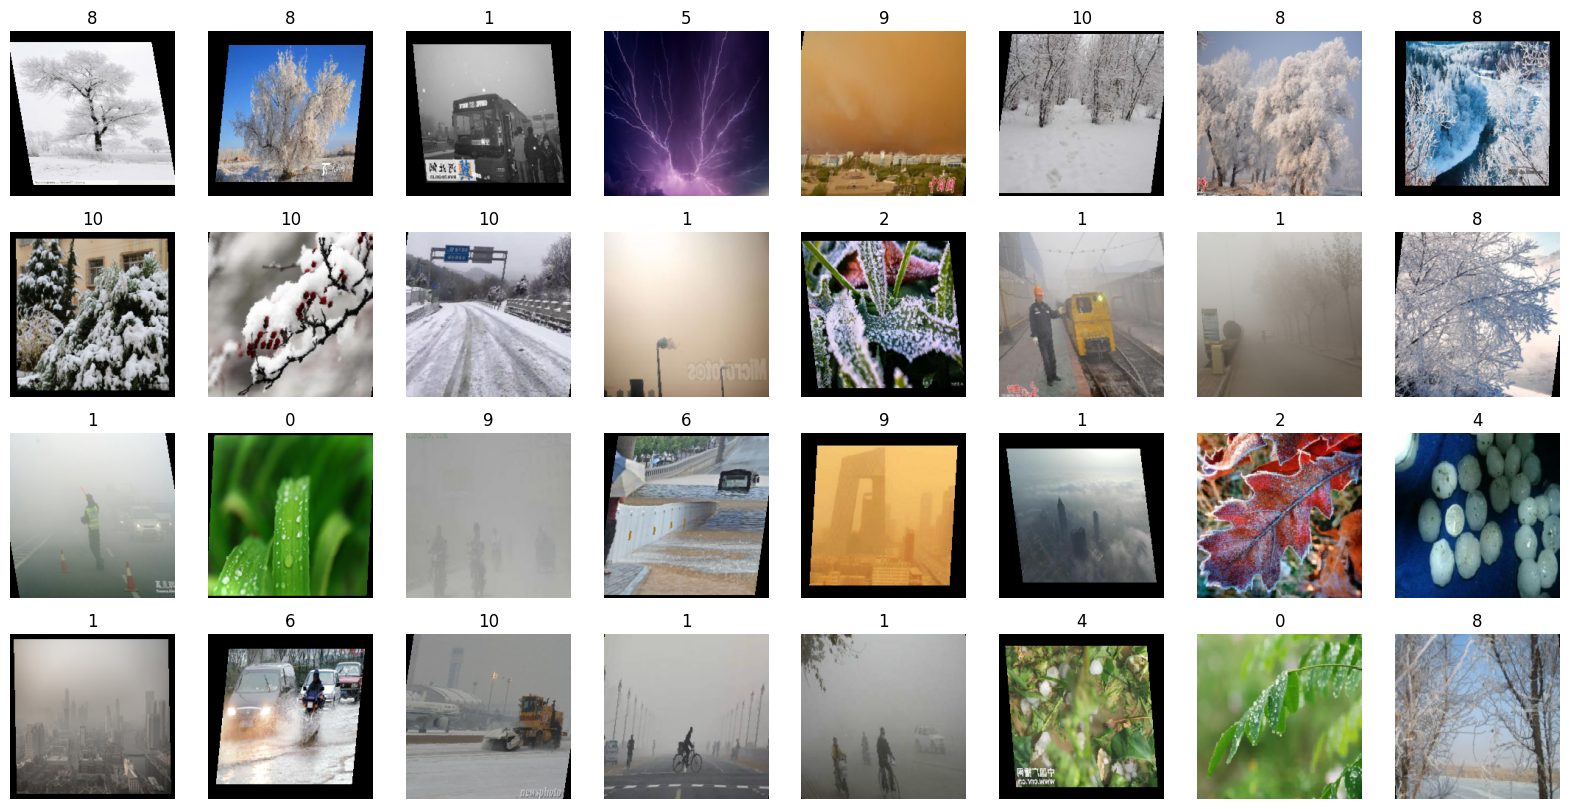

In [ ]:
imgs, labels = next(iter(train_dataloader))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label.item())
    ax.axis("off")

In [ ]:
for i in range(11):
    print(f"class {i}: {datasets.classes[i]}")

class 0: dew
class 1: fogsmog
class 2: frost
class 3: glaze
class 4: hail
class 5: lightning
class 6: rain
class 7: rainbow
class 8: rime
class 9: sandstorm
class 10: snow


In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [ ]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [ ]:
# 사전 학습된 EfficientNetB4 모델
efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model = efficientnet_b4(weights="DEFAULT").to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1792, 896),
    nn.ReLU(),
    nn.Linear(896, 11)
).to(device)

model = model.to(device)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# 학습

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        sum_losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(train_dataloader)
    avg_acc = sum_accs / len(train_dataloader)
    print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

KeyboardInterrupt: 

In [ ]:
# 평가

model.eval()

sum_losses = 0
sum_accs = 0

for x_batch, y_batch in val_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch)
    loss = nn.CrossEntropyLoss()(y_pred, y_batch)

    sum_losses += loss

    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_loss = sum_losses / len(val_dataloader)
avg_acc = sum_accs / len(val_dataloader)

print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

# 1-2. DenseNet 모델 사용

In [ ]:
def split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2):
    # 클래스 폴더 목록 가져오기
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        validation_class_path = os.path.join(validation_path, class_name)

        # 폴더 생성
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(validation_class_path):
            os.makedirs(validation_class_path)

        # 클래스 폴더 내의 파일 목록 가져오기
        file_list = os.listdir(class_path)

        # 클래스 별 데이터셋 섞기
        random.shuffle(file_list)

        # 클래스 별 데이터셋을 train과 validation으로 나누기
        num_validation = int(len(file_list) * validation_ratio)
        validation_files = file_list[:num_validation]
        train_files = file_list[num_validation:]

        # validation 폴더로 파일 이동
        for file in validation_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(validation_class_path, file)
            shutil.move(src_path, dest_path)

        # train 폴더로 파일 이동
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(train_class_path, file)
            shutil.move(src_path, dest_path)

# 사용 예시
dataset_path = 'dataset'
train_path = 'train'
validation_path = 'validation'

split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2)

In [ ]:
train_list_dew = os.listdir('train/dew')
valid_list_dew = os.listdir('validation/dew')

print(len(train_list_dew), len(valid_list_dew))

559 139


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

def target_transforms(target):
    return torch.FloatTensor([target])

image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train']),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'])
}

# label을 float형으로 변경함
# label의 차원이 2D임, 각 요소는 1D
# target_transform=target_transforms를 하지 않으면 각 요소는 long타입에 0D임

cuda


In [ ]:
print(len(image_datasets['train']), len(image_datasets['validation']))

5493 1369


In [ ]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [ ]:
x_batch, y_batch = next(iter(dataloaders['train']))
print(y_batch.shape)
print(x_batch.shape)

torch.Size([32])
torch.Size([32, 3, 224, 224])


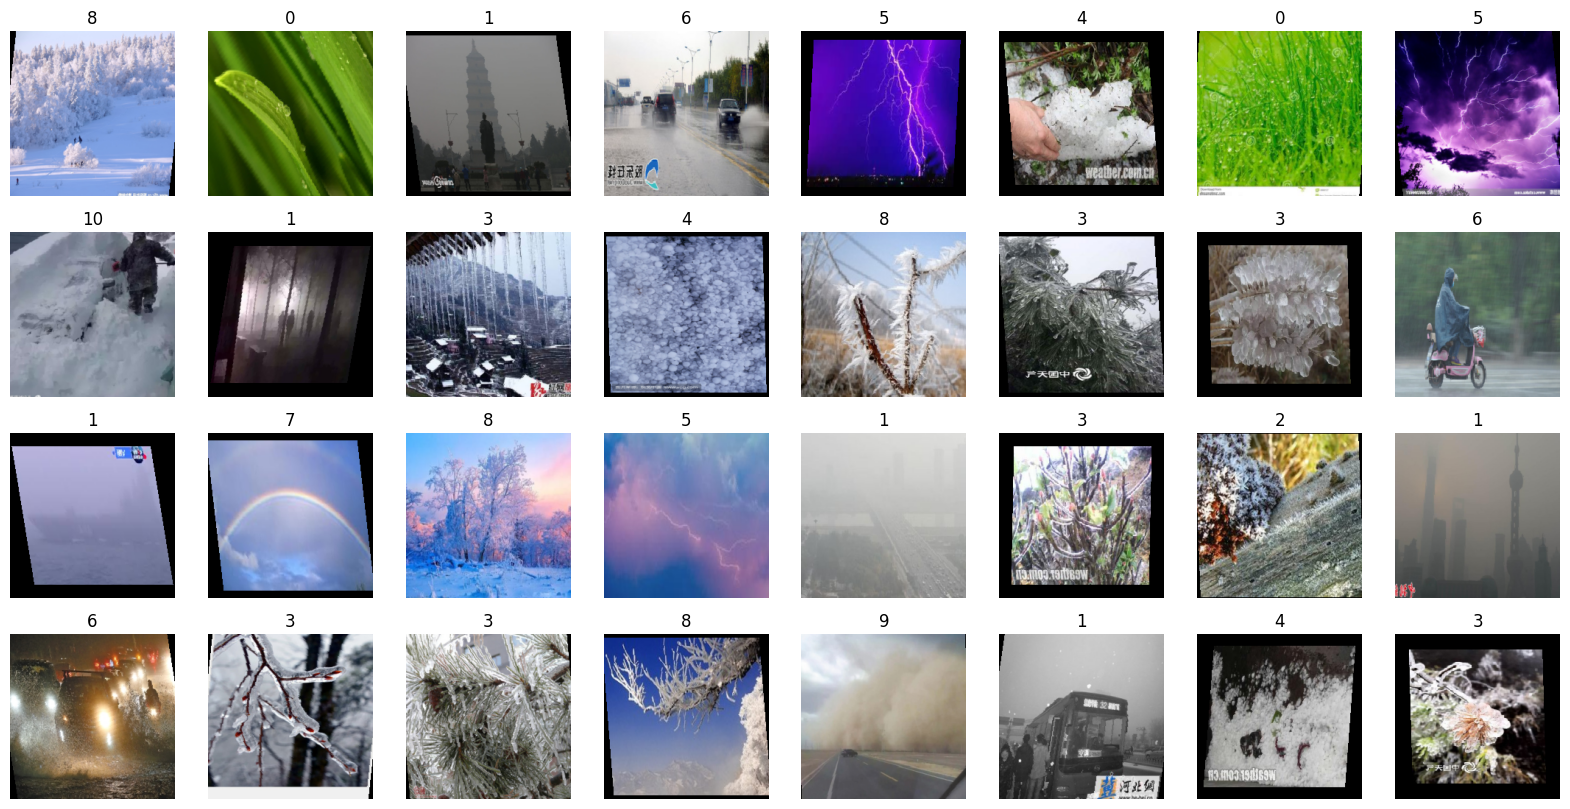

In [ ]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

### 1. First Model

In [ ]:
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        # Pre-trained DenseNet121 모델을 불러오기
        self.densenet121 = models.densenet121(pretrained=True)

        # 마지막 fully connected layer의 입력 크기를 수정하여 원하는 클래스 수에 맞추기
        in_features = self.densenet121.classifier.in_features

        # 기존의 DenseNet121dml classifier 레이어 동결
        for param in self.densenet121.parameters():
            param.requires_grad = False

        # 새로운 classifier 레이어 추가
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Sigmoid(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Forward pass를 정의
        x = self.densenet121(x)
        return x

# 모델 생성 및 예제 출력
num_classes = 11  # 분류할 클래스 수에 맞게 설정
model = DenseNet121Model(num_classes).to(device)

# 모델 구조 출력
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 108MB/s]


DenseNet121Model(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders['train']:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        sum_losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(dataloaders['train'])
    avg_acc = sum_accs / len(dataloaders['train'])
    print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:    0/10 Loss: 1.539101 Accuracy: 54.09%
Epoch:    1/10 Loss: 0.771504 Accuracy: 77.71%
Epoch:    2/10 Loss: 0.561809 Accuracy: 83.55%
Epoch:    3/10 Loss: 0.490245 Accuracy: 84.68%
Epoch:    4/10 Loss: 0.428401 Accuracy: 86.11%
Epoch:    5/10 Loss: 0.416136 Accuracy: 86.65%
Epoch:    6/10 Loss: 0.389964 Accuracy: 86.83%
Epoch:    7/10 Loss: 0.367264 Accuracy: 87.54%
Epoch:    8/10 Loss: 0.347987 Accuracy: 88.48%
Epoch:    9/10 Loss: 0.350328 Accuracy: 88.25%
Epoch:   10/10 Loss: 0.335398 Accuracy: 88.77%


In [ ]:
# 평가

model.eval()

sum_losses = 0
sum_accs = 0

for x_batch, y_batch in dataloaders['validation']:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch)
    loss = nn.CrossEntropyLoss()(y_pred, y_batch)

    sum_losses += loss

    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_loss = sum_losses / len(dataloaders['validation'])
avg_acc = sum_accs / len(dataloaders['validation'])

print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:   10/10 Loss: 0.380300 Accuracy: 87.06%


In [ ]:
# 학습된 모델 파일 저장
torch.save(model.state_dict(), "model_densenet121_first.pth") # model.h5 : TensorFlow 저장, pth : 파이토치 저장

### 2. Second Model

In [ ]:
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        # Pre-trained DenseNet121 모델을 불러오기
        self.densenet121 = models.densenet121(pretrained=True)

        # 마지막 fully connected layer의 입력 크기를 수정하여 원하는 클래스 수에 맞추기
        in_features = self.densenet121.classifier.in_features

        # 기존의 DenseNet121dml classifier 레이어 동결
        for param in self.densenet121.parameters():
            param.requires_grad = False

        # 새로운 classifier 레이어 추가
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),      # ReLU 계층 하나 더 추가
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # Forward pass를 정의
        x = self.densenet121(x)
        return x

# 모델 생성 및 예제 출력
num_classes = 11  # 분류할 클래스 수에 맞게 설정
model = DenseNet121Model(num_classes).to(device)

# 모델 구조 출력
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet121Model(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders['train']:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        sum_losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(dataloaders['train'])
    avg_acc = sum_accs / len(dataloaders['train'])
    print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:    0/10 Loss: 1.797452 Accuracy: 46.48%
Epoch:    1/10 Loss: 1.074285 Accuracy: 70.17%
Epoch:    2/10 Loss: 0.800520 Accuracy: 75.92%
Epoch:    3/10 Loss: 0.647819 Accuracy: 81.27%
Epoch:    4/10 Loss: 0.567988 Accuracy: 83.38%
Epoch:    5/10 Loss: 0.498888 Accuracy: 85.12%
Epoch:    6/10 Loss: 0.463245 Accuracy: 85.97%
Epoch:    7/10 Loss: 0.432987 Accuracy: 86.30%
Epoch:    8/10 Loss: 0.413331 Accuracy: 87.16%
Epoch:    9/10 Loss: 0.384062 Accuracy: 87.74%
Epoch:   10/10 Loss: 0.368384 Accuracy: 88.26%


In [ ]:
# 평가

model.eval()

sum_losses = 0
sum_accs = 0

for x_batch, y_batch in dataloaders['validation']:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch)
    loss = nn.CrossEntropyLoss()(y_pred, y_batch)

    sum_losses += loss

    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_loss = sum_losses / len(dataloaders['validation'])
avg_acc = sum_accs / len(dataloaders['validation'])

print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:   10/10 Loss: 0.387434 Accuracy: 87.28%


In [ ]:
# 학습된 모델 파일 저장
torch.save(model.state_dict(), "model_densenet121_second.pth") # model.h5 : TensorFlow 저장, pth : 파이토치 저장

### 3. Third Model

In [ ]:
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        # Pre-trained DenseNet121 모델을 불러오기
        self.densenet121 = models.densenet121(pretrained=True)

        # 마지막 fully connected layer의 입력 크기를 수정하여 원하는 클래스 수에 맞추기
        in_features = self.densenet121.classifier.in_features

        # 기존의 DenseNet121dml classifier 레이어 동결
        for param in self.densenet121.parameters():
            param.requires_grad = False

        # 새로운 classifier 레이어 추가
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),      # ReLU 계층 하나 더 추가
            nn.Linear(128, 64),
            nn.ReLU(),      # ReLU 계층 하나 더 추가
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # Forward pass를 정의
        x = self.densenet121(x)
        return x

# 모델 생성 및 예제 출력
num_classes = 11  # 분류할 클래스 수에 맞게 설정
model = DenseNet121Model(num_classes).to(device)

# 모델 구조 출력
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet121Model(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders['train']:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        sum_losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(dataloaders['train'])
    avg_acc = sum_accs / len(dataloaders['train'])
    print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:    0/10 Loss: 1.825788 Accuracy: 39.63%
Epoch:    1/10 Loss: 1.231110 Accuracy: 60.17%
Epoch:    2/10 Loss: 0.975709 Accuracy: 69.40%
Epoch:    3/10 Loss: 0.800677 Accuracy: 75.00%
Epoch:    4/10 Loss: 0.706151 Accuracy: 77.73%
Epoch:    5/10 Loss: 0.633042 Accuracy: 79.05%
Epoch:    6/10 Loss: 0.574064 Accuracy: 81.37%
Epoch:    7/10 Loss: 0.544575 Accuracy: 82.41%
Epoch:    8/10 Loss: 0.522879 Accuracy: 82.42%
Epoch:    9/10 Loss: 0.504447 Accuracy: 83.61%
Epoch:   10/10 Loss: 0.457891 Accuracy: 84.97%


In [ ]:
# 평가

model.eval()

sum_losses = 0
sum_accs = 0

for x_batch, y_batch in dataloaders['validation']:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch)
    loss = nn.CrossEntropyLoss()(y_pred, y_batch)

    sum_losses += loss

    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_loss = sum_losses / len(dataloaders['validation'])
avg_acc = sum_accs / len(dataloaders['validation'])

print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:   10/10 Loss: 0.458827 Accuracy: 85.23%


In [ ]:
# 학습된 모델 파일 저장
torch.save(model.state_dict(), "model_densenet121_third.pth") # model.h5 : TensorFlow 저장, pth : 파이토치 저장

### 4. Fourth Model

In [ ]:
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        # Pre-trained DenseNet121 모델을 불러오기
        self.densenet121 = models.densenet121(pretrained=True)

        # 마지막 fully connected layer의 입력 크기를 수정하여 원하는 클래스 수에 맞추기
        in_features = self.densenet121.classifier.in_features

        # 기존의 DenseNet121dml classifier 레이어 동결
        for param in self.densenet121.parameters():
            param.requires_grad = False

        # 새로운 classifier 레이어 추가
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(negative_slope=0.01),      # ReLU 함수를 LeakyReLU 함수로 변환
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # Forward pass를 정의
        x = self.densenet121(x)
        return x

# 모델 생성 및 예제 출력
num_classes = 11  # 분류할 클래스 수에 맞게 설정
model = DenseNet121Model(num_classes).to(device)

# 모델 구조 출력
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet121Model(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders['train']:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        sum_losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(dataloaders['train'])
    avg_acc = sum_accs / len(dataloaders['train'])
    print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:    0/10 Loss: 1.789863 Accuracy: 42.41%
Epoch:    1/10 Loss: 1.179473 Accuracy: 64.30%
Epoch:    2/10 Loss: 0.881313 Accuracy: 75.41%
Epoch:    3/10 Loss: 0.696729 Accuracy: 79.99%
Epoch:    4/10 Loss: 0.611169 Accuracy: 81.90%
Epoch:    5/10 Loss: 0.547053 Accuracy: 83.48%
Epoch:    6/10 Loss: 0.507146 Accuracy: 83.93%
Epoch:    7/10 Loss: 0.457474 Accuracy: 86.05%
Epoch:    8/10 Loss: 0.440224 Accuracy: 86.25%
Epoch:    9/10 Loss: 0.419255 Accuracy: 86.84%
Epoch:   10/10 Loss: 0.386168 Accuracy: 87.67%


In [ ]:
# 평가

model.eval()

sum_losses = 0
sum_accs = 0

for x_batch, y_batch in dataloaders['validation']:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch)
    loss = nn.CrossEntropyLoss()(y_pred, y_batch)

    sum_losses += loss

    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_loss = sum_losses / len(dataloaders['validation'])
avg_acc = sum_accs / len(dataloaders['validation'])

print(f"Epoch: {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%")

Epoch:   10/10 Loss: 0.404055 Accuracy: 86.80%


In [ ]:
# 학습된 모델 파일 저장
torch.save(model.state_dict(), "model_densenet121_forth.pth") # model.h5 : TensorFlow 저장, pth : 파이토치 저장

# 인사이트
* First Model : 1 * ReLU() + Sigmoid()
    * In Test
        * Loss: 0.380300
        + Accuracy: 87.06%
* Second Model : 2 * ReLU() + Sigmoid()
    * In Test
        * Loss: 0.387434
        * Accuracy: 87.28%
* Third Model : 3 * ReLU() + Sigmoid()
    * In Test
        * Loss: 0.458827
        * Accuracy: 85.23%
* Fourth Model : 3 * LeakyReLU() + Sigmoid()
    * In Test
        * Loss: 0.404055
        * Accuracy: 86.80%


* 미세한 차이지만 2개의 ReLU를 사용한 것이 가장 성능이 좋았다. 3개의 ReLU 부터는 성능이 오히려 떨어지는 것을 알 수 있는데 과적합이나 Dead Neurons, 경사 폭주(exploding gradients), 경사 소실(vanishing gradients) 때문일 가능성도 있다.
* Dead Neurons 라고 가정하고 이를 해결해 보는 방법으로 LeakyReLU 함수를 사용했는데 성능이 조금 좋아진 것으로 보아 영향이 조금은 있었던 것이라고 판단할 수 있다.
* 더 이상의 성능 향상을 기대하기 어려운데 이것은 DenseNet121 모델 자체의 상한선이 아닐까 생각된다

